In [1]:
from haplogone import read_vcf, process_vcf_baf, segment_baf, filter_segments_by_size

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.mixture import GaussianMixture

In [2]:
female = read_vcf('../../bioinf_semester_project/data/sample_1/gatk_called.vcf')
male = read_vcf("../../bioinf_semester_project/data/sample_2/gatk_called.vcf")

In [3]:
female = process_vcf_baf(female)
male = process_vcf_baf(male)

In [4]:
male.groupby("#CHROM").agg({"BAF": "mean"})


,BAF
#CHROM,
chr1,0.745909
chr10,0.746595
chr11,0.741789
chr12,0.748704
chr13,0.751870
chr14,0.739895
chr15,0.764247
chr16,0.728821
chr17,0.729682


In [5]:
female.groupby("#CHROM").agg({"BAF": "mean"})

,BAF
#CHROM,
chr1,0.740880
chr10,0.741892
chr11,0.747873
chr12,0.745644
chr13,0.755741
chr14,0.748776
chr15,0.747184
chr16,0.746703
chr17,0.741373


In [6]:
# female[female["#CHROM"] == "chrX"]

In [7]:
female = segment_baf(female[female["#CHROM"] == "chrX"], shuffles=10000, p=1e-100)
male = segment_baf(male[male["#CHROM"] == "chrX"], shuffles=10000, p=1e-100)

In [8]:
female["BAF_segment"].unique().shape

(1,)

In [9]:
# male["BAF_segment"].unique().shape

In [10]:
# male

In [11]:
# filter_segments_by_size(male, threshold=0)

In [12]:
# df = (
#     male.groupby("BAF_segment")
#     .agg({"POS": ["min", "max"]})["POS"]
#     .reset_index()
#     .sort_values(["min"])
# )
# df["segment_length"] = df["max"] - df["min"]
# df.reset_index(drop=True)

In [13]:
# male.agg({'BAF': ['min', 'max']})

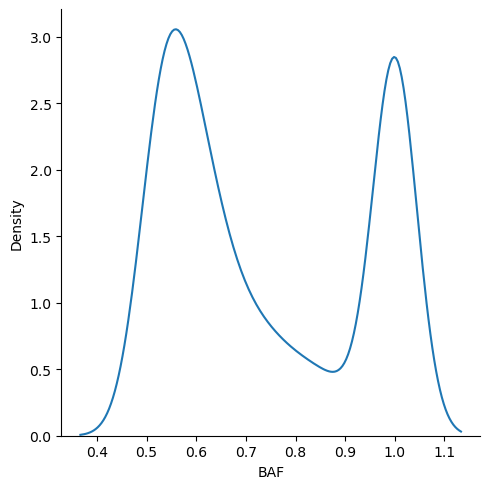

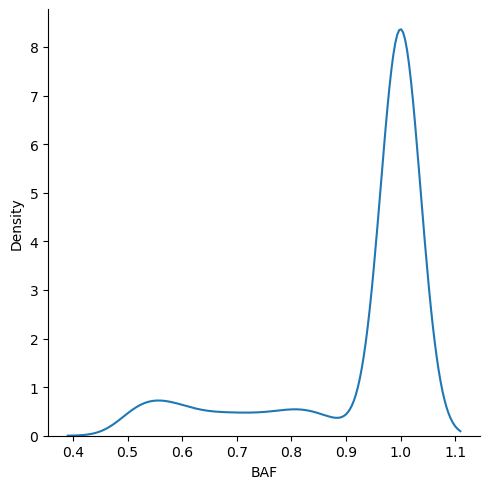

In [14]:
sns.displot(female, x="BAF", kind="kde")
sns.displot(male, x="BAF", kind="kde")

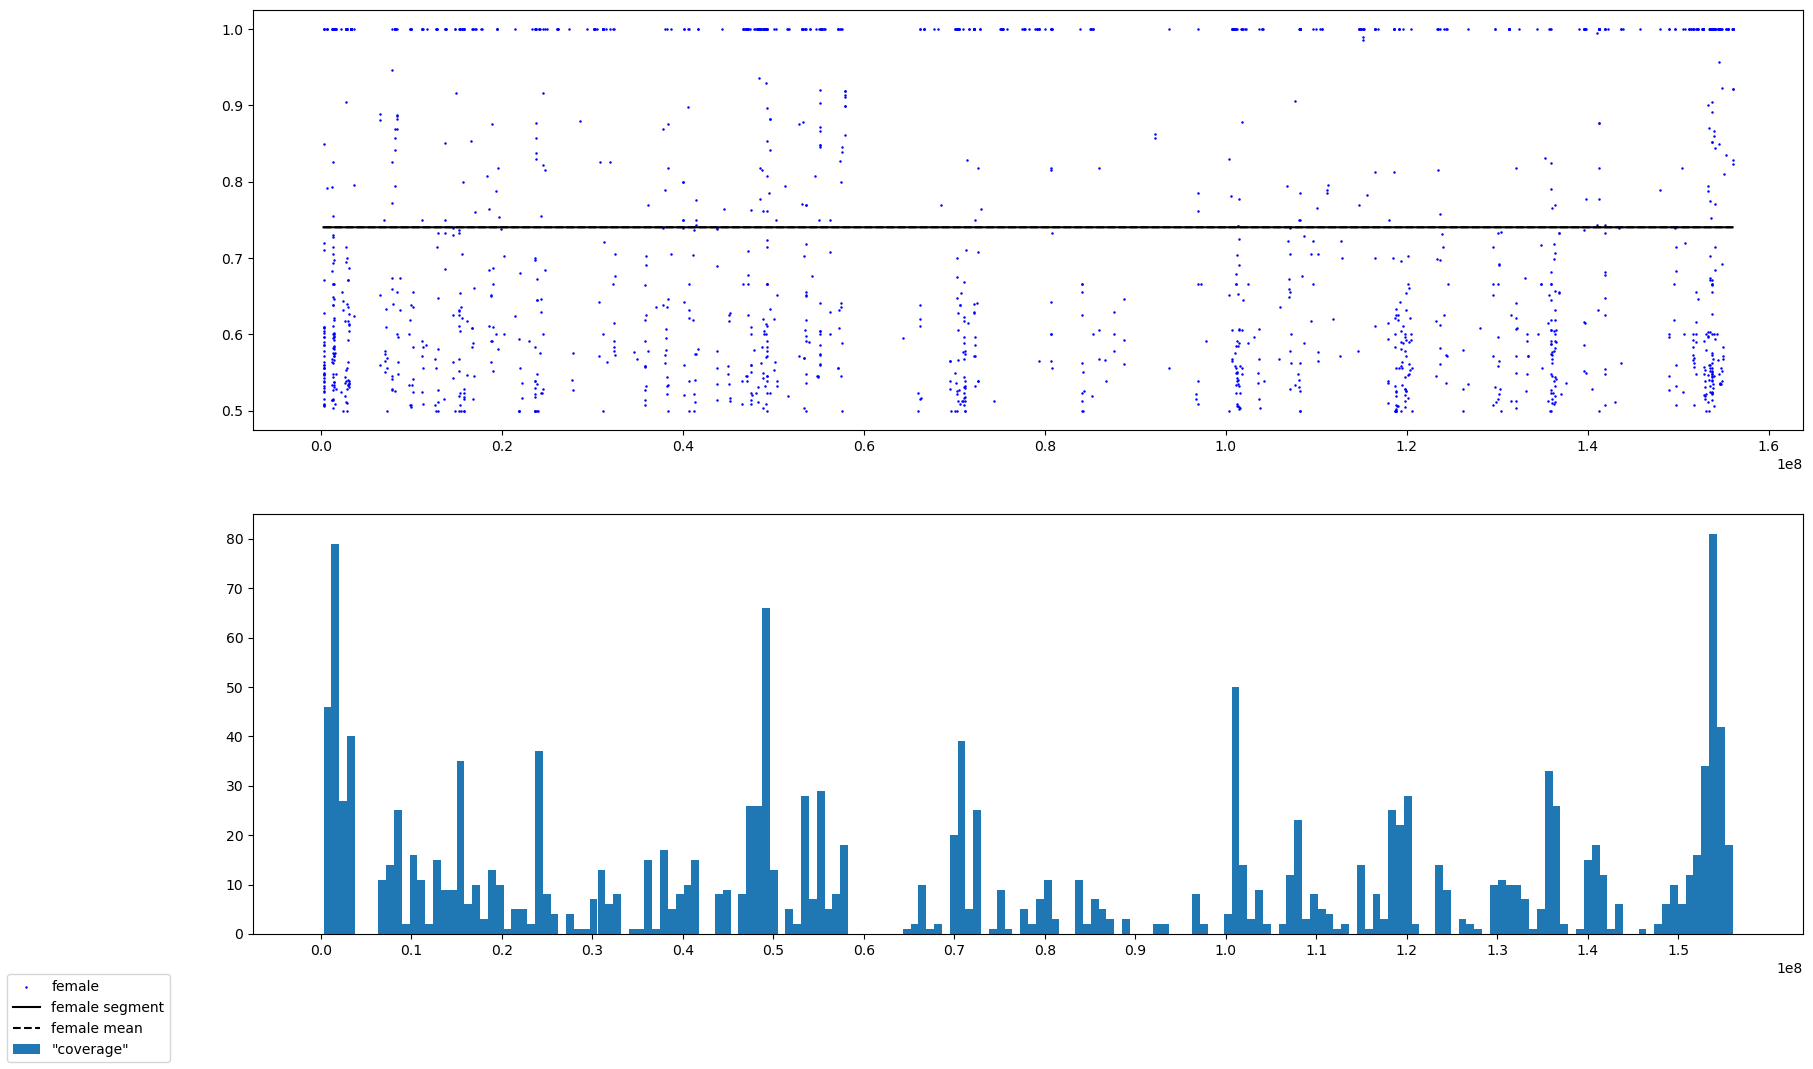

In [15]:
df_vcf, gender = female, "female"

fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(
    df_vcf["POS"],
    df_vcf["BAF"],
    s=0.6,
    c="b",
    marker="o",
    label=f"{gender}",
)

ax1.plot(
    df_vcf["POS"],
    df_vcf["BAF_segment"],
    c="black",
    label=f"{gender} segment",
)

ax1.plot(
    df_vcf["POS"],
    np.full(len(df_vcf["POS"]), np.mean(df_vcf["BAF_segment"])),
    c="black",
    label=f"{gender} mean",
    linestyle="--",
)

ax2.hist(
    df_vcf["POS"],
    bins=180,
    label=f'"coverage"',
)


plt.xticks(np.arange(0, max(df_vcf["POS"]), step=1e7))
fig.legend(loc="lower left");

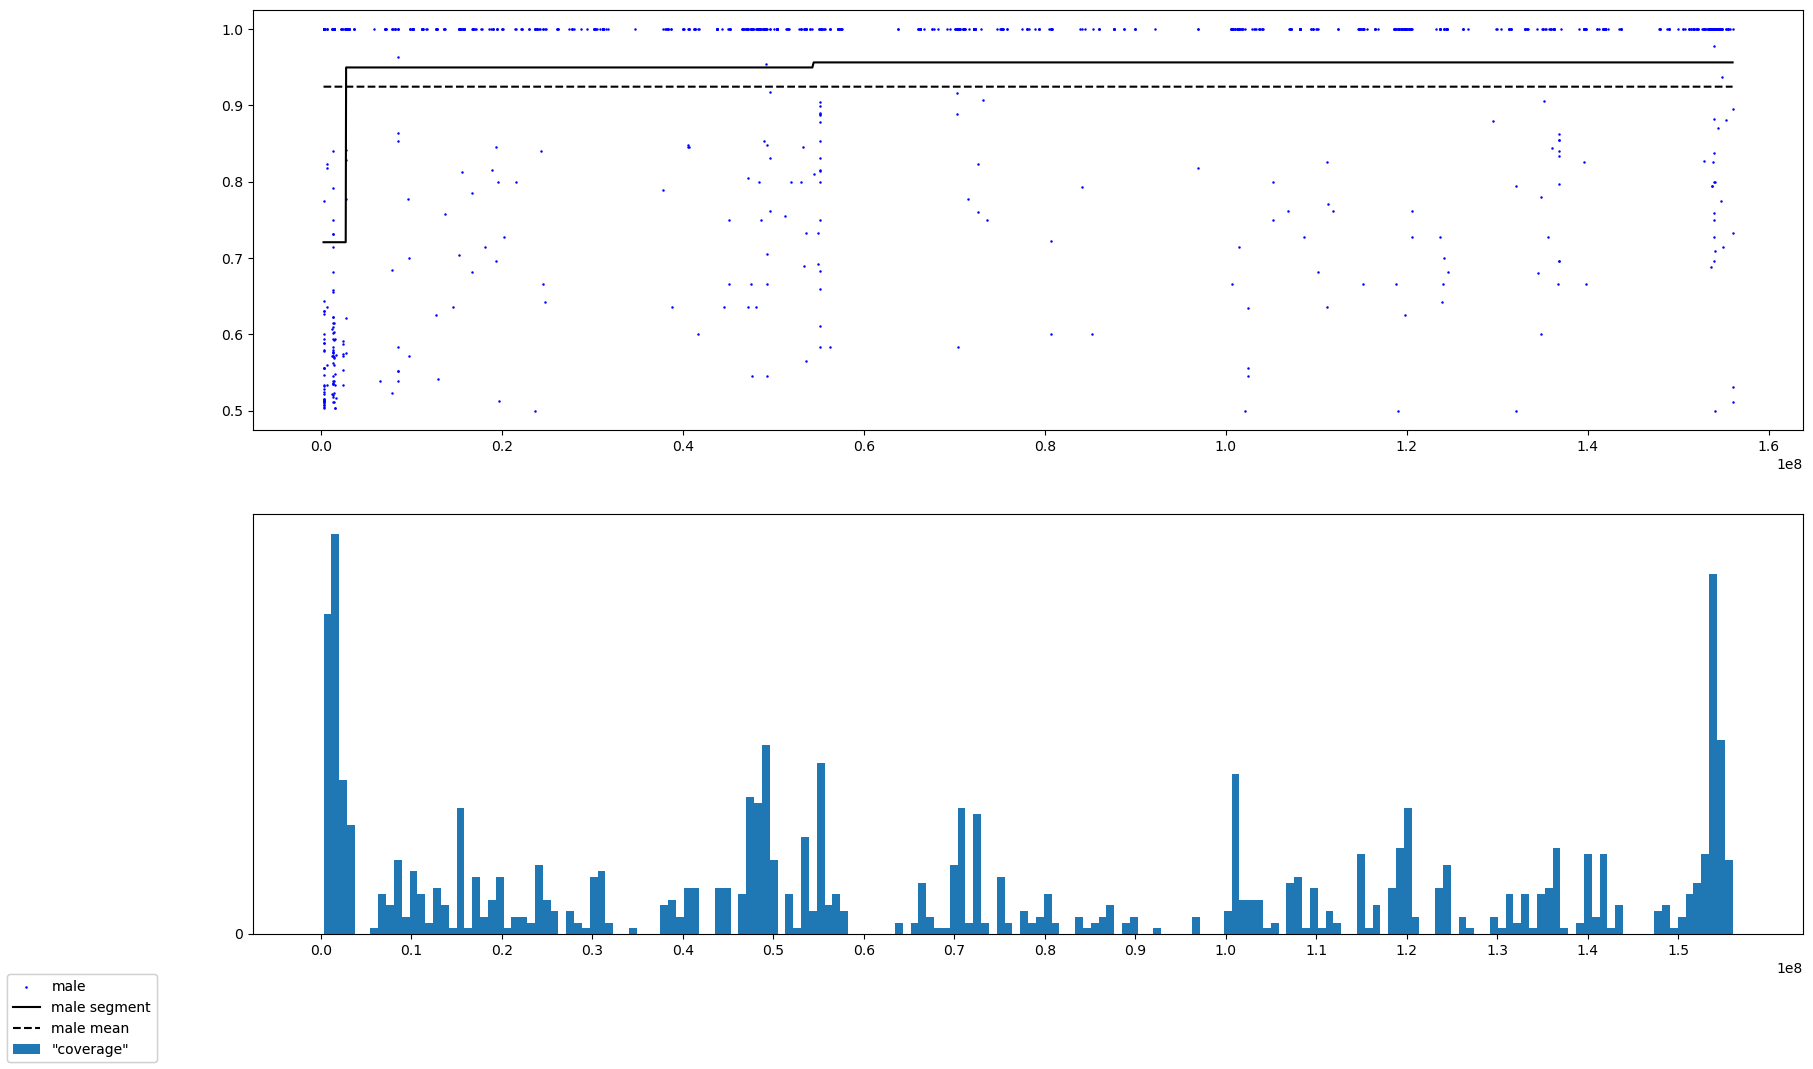

In [16]:
df_vcf, gender = male, "male"

fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(
    df_vcf["POS"],
    df_vcf["BAF"],
    s=0.6,
    c="b",
    marker="o",
    label=f"{gender}",
)

ax1.plot(
    df_vcf["POS"],
    df_vcf["BAF_segment"],
    c="black",
    label=f"{gender} segment",
)

ax1.plot(
    df_vcf["POS"],
    np.full(len(df_vcf["POS"]), np.mean(df_vcf["BAF_segment"])),
    c="black",
    label=f"{gender} mean",
    linestyle="--",
)

ax2.hist(
    df_vcf["POS"],
    bins=180,
    label=f'"coverage"',
)


plt.xticks(np.arange(0, max(df_vcf["POS"]), step=1e7))
fig.legend(loc="lower left")
plt.xticks(np.arange(0, max(df_vcf["POS"]), step=1e7))
plt.yticks(np.arange(0, 1))
fig.legend(loc="lower left")

In [17]:
X = np.array(male["BAF"])
gmm = GaussianMixture(n_components=2).fit(X.reshape(-1, 1))

y = gmm.predict(X.reshape(-1, 1))
print(y.sum())

X = np.array(male["BAF_segment"])
y = gmm.predict(X.reshape(-1, 1))
print(sum(y))

267
1124


In [79]:
X = np.array(male["BAF"])
gmm = GaussianMixture(n_components=2).fit(X.reshape(-1, 1))

X = np.array(male["BAF_segment"])
male["pred"] = y = gmm.predict(X.reshape(-1, 1))

# X = np.array(female["BAF_segment"])
# y = gmm.predict(X.reshape(-1, 1))
# print(sum(y))

In [80]:
mask_0 = y == 0
mask_1 = y == 1
print(sum(mask_0))
print(sum(mask_1))

0
1124


In [81]:
male["BAF"][0.9 < male["BAF"]].unique()

array([1.        , 0.96296296, 0.95454545, 0.91705069, 0.9047619 ,
       0.91666667, 0.90697674, 0.90625   , 0.97826087, 0.9375    ])

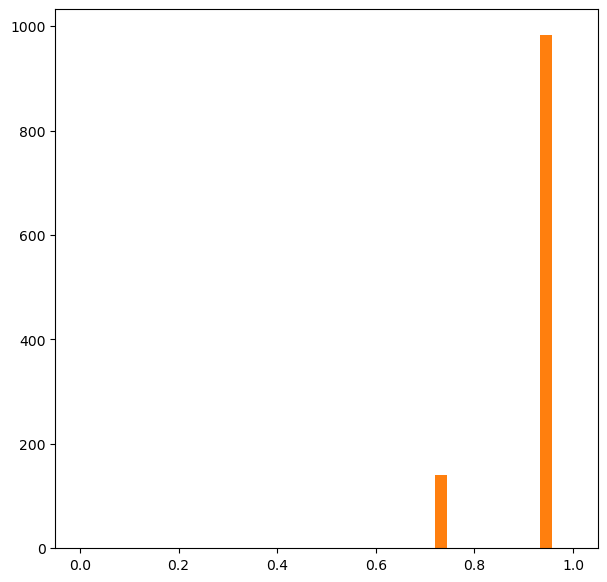

In [83]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)

ax1.hist(
    male["BAF_segment"][male['pred'] == 0],
    bins=10,
    label=f"0",
)
ax1.hist(
    male["BAF_segment"][male["pred"] == 1],
    bins=10,
    label=f"1",
)
plt.show()